# GARBAGE DETECTOR

### Importing Necessary Packages

In [5]:
import os
import numpy as np
from bs4 import BeautifulSoup
from imutils import paths
import cv2
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.estimator import model_to_estimator

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image
import imutils


### Configuring directories and paths

In [2]:
orig_base_path = r"D:\garbage"
orig_images = os.path.sep.join([orig_base_path,'images'])
orig_annots = os.path.sep.join([orig_base_path,'annotations'])
base_path = r"D:\garbage\dataset"
positive_path = os.path.sep.join([base_path,"garbage"])
negative_path = os.path.sep.join([base_path,"no_garbage"])

max_proposal = 1000
max_proposal_infer = 200

max_positive = 30
max_negative = 10

input_dims = (224,224)

model_path = "garbage_detector.h5"
encoder_path = "garbage_label_encoder.pickle"

min_prob = 0.90

### Intersection Over Union (IOU)

In [3]:
def compute_iou(boxA,boxB):
    xA = max(boxA[0],boxB[0])
    yA = max(boxA[1],boxB[1])
    xB = max(boxA[2],boxB[2])
    yB = max(boxA[3],boxB[3])
    
    interArea = max(0,xB-xA+1)*max(0,yB-yA+1)
    boxAArea = (boxA[2]-boxA[0]+1)*(boxA[3]-boxA[1]+1)
    boxBArea = (boxB[2]-boxB[0]+1)*(boxB[3]-boxB[1]+1)
    
    iou = interArea / float(boxAArea+boxBArea-interArea)
    return iou

### Non-Max Supression (NMS)

In [4]:
def non_max_supression(boxes,probs=None,overlapThresh=0.1):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == 'i':
        boxes = boxes.astype('float')
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    area = (x2-x1+1)*(y2-y1+1)
    idxs = y2
    if probs is not None:
        idxs = probs
    idxs = np.argsort(idxs)
    while len(idxs)>0:
        last = len(idxs)-1
        i = idxs[last]
        pick.append(i)
        
        xx1 = np.maximum(x1[i],x1[idxs[:last]])
        yy1 = np.maximum(y1[i],y1[idxs[:last]])
        xx2 = np.minimum(x2[i],x2[idxs[:last]])
        yy2 = np.minimum(x2[i],x2[idxs[:last]])
        
        w = np.maximum(0,xx2-xx1+1)
        h = np.maximum(0,yy2-yy1+1)
        
        overlap = (w*h)/area[idxs[:last]]
        idxs  = np.delete(idxs,np.concatenate(([last],np.where(overlap>overlapThresh)[0])))
    return pick

### Building dataset to train our model

In [ ]:
imagePaths = list(paths.list_images(orig_images))
annotPaths = list(paths.list_files(orig_annots))

for dirpath in (positive_path,negative_path):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

boxes = []
neg_boxes = []
for (i,img) in enumerate(imagePaths):
    for i in annotPaths:
        content = open(i).read()
        soup = BeautifulSoup(content,'html.parser')
        w = int(soup.find('width').string)
        h = int(soup.find('height').string)
    
        for o in soup.find_all('object'):
            xMin = int(float(o.find("xmin").string))
            yMin = int(float(o.find("ymin").string))
            xMax = int(float(o.find("xmax").string))
            yMax = int(float(o.find("ymax").string))
            
            xMin = max(0,xMin)
            yMin = max(0,yMin)
            xMax = min(w,xMax)
            yMax = min(h,yMax)

            boxes.append([i,(xMin,yMin,xMax,yMax)])
            neg_boxes.append((xMin,yMin,xMax,yMax))

In [ ]:
aug = ImageDataGenerator(rotation_range=30,width_shift_range=0.1,height_shift_range=0.1,
                        shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

###### Building for Positive class i.e. images of garbage alone

In [ ]:
filename = 0
for img in imagePaths:
    for j in range(len(annotPaths)):
        fl2 = boxes[j][0].split(os.path.sep)[-1]
        fl2 = fl2[:fl2.rfind('.')]
        fln = img
        fl1 = fln.split(os.path.sep)[-1]
        fl1 = fl1[:fl1.rfind('.')]
        if (fl2 == fl1):
            image = Image.open(fln)
            image = image.convert('RGB')
            image = image.crop(boxes[j][1])
            image = image.resize(input_dims)
            x = img_to_array(image)
            x = x.reshape((1,)+x.shape)
            i = 0
            for batch in aug.flow(x,batch_size=1,save_to_dir=positive_path,save_prefix='garbage',save_format='jpg'):
                i += 1
                if i == 10:
                    break

##### Building for Negative class i.e. images without garbage

In [ ]:
totalNegatives = 0

for (i,imagepath) in enumerate(imagePaths):
    
    image = cv2.imread(imagepath)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    proposedRects = []
    
    for (x,y,w,h) in rects:
        proposedRects.append((x,y,x+w,y+h))
    negativeROIs = 0
    
    for proposedRect in proposedRects[:max_proposal]:
        (propStartX,propStartY,propEndX,propEndY) = proposedRect
        for gtBox in neg_boxes:
            iou = compute_iou(gtBox,proposedRect)
            (gtStartX,gtStartY,gtEndX,gtEndY) = gtBox
            
            roi = None
            outputPath = None
            
            if iou < 0.05 and negativeROIs <= max_negative:
                roi = image[propStartY:propEndY,propStartX:propEndX]
                filename = "{}.png".format(totalNegatives)
                outputPath = os.path.sep.join([negative_path,filename])
                negativeROIs += 1
                totalNegatives += 1
            
            if roi is not None and outputPath is not None:
                roi = cv2.resize(roi,input_dims,interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath,roi)

#### Model Building

C:\Users\prith\anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


  ...
    to  
  ['...']
Train for 40 steps, validate on 324 samples
Epoch 1/5
40/40 [==============================] - 16s 392ms/step - loss: 0.5227 - accuracy: 0.7350 - val_loss: 0.1719 - val_accuracy: 0.9531
Epoch 2/5
40/40 [==============================] - 12s 311ms/step - loss: 0.2065 - accuracy: 0.9375 - val_loss: 0.0967 - val_accuracy: 0.9625
Epoch 3/5
40/40 [==============================] - 13s 316ms/step - loss: 0.1451 - accuracy: 0.9470 - val_loss: 0.0787 - val_accuracy: 0.9625
Epoch 4/5
40/40 [==============================] - 13s 325ms/step - loss: 0.1187 - accuracy: 0.9652 - val_loss: 0.0617 - val_accuracy: 0.9812
Epoch 5/5
40/40 [==============================] - 13s 315ms/step - loss: 0.0966 - accuracy: 0.9691 - val_loss: 0.0566 - val_accuracy: 0.9812
              precision    recall  f1-score   support

     garbage       0.97      0.99      0.98       152
  no_garbage       0.99      0.98      0.98       172

    accuracy                           0.98       324
   

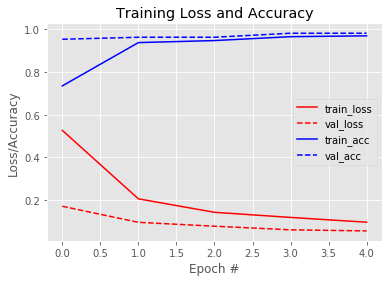

<Figure size 432x288 with 0 Axes>

In [8]:
lr = 1e-4
epoch = 5
bs = 32

imagePaths = list(paths.list_images(base_path))
data  = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath,target_size=input_dims)
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

data = np.array(data,dtype='float32')
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(xtrain,xtest,ytrain,ytest) = train_test_split(data,labels,test_size=0.2,stratify=labels,random_state=42)

aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                        height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,
                        fill_mode="nearest")

baseModel = MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation='softmax')(headModel)

model = Model(inputs=baseModel.input,outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False
    
opt = Adam(learning_rate=lr)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

history = model.fit(aug.flow(xtrain,ytrain,batch_size=bs),steps_per_epoch=len(xtrain)//bs,
                   validation_data=(xtest,ytest),validation_steps=len(xtest)//bs,epochs=epoch)

predIdxs = model.predict(xtest,batch_size=bs)
predIdxs = np.argmax(predIdxs,axis=1)

print(classification_report(ytest.argmax(axis=1),predIdxs,target_names=lb.classes_))

model.save(model_path,save_format='h5')
f = open(encoder_path,'wb')
f.write(pickle.dumps(lb))
f.close()

N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"],'-r', label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"],'--r', label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"],'-b', label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"],'--b', label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.show()
plt.savefig('garbage_model.png')



### Detector Model - RCNN

In [ ]:
model = load_model('garbage_detector.h5')
lb = pickle.loads(open(encoder_path,'rb').read())

In [ ]:
image_path = r'C:\Users\prith\garbage0.jpg'
image = cv2.imread(image_path)
image = imutils.resize(image,width=500)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

proposals = []
boxes = []

for (x,y,w,h) in rects[:max_proposal_infer]:
    roi = image[y:y+h,x:x+w]
    roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi,input_dims,interpolation=cv2.INTER_CUBIC)
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    
    proposals.append(roi)
    boxes.append((x,y,x+w,y+h))
    
proposals = np.array(proposals,dtype='float32')
boxes = np.array(boxes,dtype='int32')

print('proposal shape {}'.format(proposals.shape))

proba = model.predict(proposals)
labels = lb.classes_[np.argmax(proba,axis=1)]
idxs = np.where(labels == 'garbage')[0]


boxes = boxes[idxs]
proba = proba[idxs][:,0]

idxs = np.where(proba >= min_prob)
boxes = boxes[idxs]
proba = proba[idxs]

clone = image.copy()

for box,prob in zip(boxes,proba):
    (startX,startY,endX,endY) = box
    cv2.rectangle(image,(startX,startY),(endX,endY),(255,255,255),2)
    y = startY-10 if startY-10 >10 else startY+10
    text = "Garbage: {:.2f}%".format(prob*100)
    cv2.putText(image,text,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0,255,0),2)
cv2.imshow("before nms",image)
cv2.waitKey(0)

boxIdxs = non_max_supression(boxes,proba)
for i in boxIdxs:
    (startX,startY,endX,endY) = boxes[i]
    cv2.rectangle(clone,(startX,startY),(endX,endY),(255,255,255),2)
    y = startY-10 if startY-10 >10 else startY+10
    text = "Garbage: {:.2f}%".format(prob*100)
    cv2.putText(clone,text,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0,0,255),2)
cv2.imshow("after nms",clone)
cv2.waitKey(0)
